In [20]:
# إعدادات النطاقات
safe_temperature = (10, 40)  # النطاق الآمن للحرارة
warning_temperature = (10, 50)  # النطاق التحذيري للحرارة


safe_humidity = (30, 80)
warning_humidity = (0, 90)

safe_smoke = (0, 300)
warning_smoke = (300, 1000)

safe_co = (0, 20)
warning_co = (20, 50)

# إعدادات لتوليد البيانات
n_samples = 2000  # عدد العينات
n_outliers = 200  # عدد العينات الشاذة

# دالة لتوليد البيانات
def generate_data():
    # قيم طبيعية (ضمن النطاق الآمن)
    temperature = np.random.randint(safe_temperature[0], safe_temperature[1], n_samples - n_outliers)
    humidity = np.random.randint(safe_humidity[0], safe_humidity[1], n_samples - n_outliers)
    smoke = np.random.randint(safe_smoke[0], safe_smoke[1], n_samples - n_outliers)
    co = np.random.randint(safe_co[0], safe_co[1], n_samples - n_outliers)

    # قيم شاذة (خارج النطاق الآمن)
    outlier_temperature = np.random.randint(warning_temperature[0], warning_temperature[1], n_outliers)
    outlier_humidity = np.random.randint(warning_humidity[0], warning_humidity[1], n_outliers)
    outlier_smoke = np.random.randint(warning_smoke[0], warning_smoke[1], n_outliers)
    outlier_co = np.random.randint(warning_co[0], warning_co[1], n_outliers)

    # دمج البيانات الطبيعية والشاذة
    temperature = np.concatenate((temperature, outlier_temperature))
    humidity = np.concatenate((humidity, outlier_humidity))
    smoke = np.concatenate((smoke, outlier_smoke))
    co = np.concatenate((co, outlier_co))

    # دمج البيانات في DataFrame
    data = pd.DataFrame({
        'Temperature_C': temperature,
        'Humidity_Percentage': humidity,
        'SmokeLevel_PPM': smoke,
        'CarbonMonoxideLevel_PPM': co,
        'FlameIntensity': flame
    })

    return data
# generate_data()
# data = generate_data() 
# data.to_csv('output_file_name.csv', index=False)


Outliers detected:
      Temperature_C  Humidity_Percentage  SmokeLevel_PPM  \
1800       6.814698            97.442817      646.465896   
1801       6.814698            97.442817     1292.181642   
1802       6.814698            12.598252     1292.181642   
1803       6.814698            12.598252      646.465896   
1804       6.814698            97.442817      646.465896   
...             ...                  ...             ...   
1995       6.814698            97.442817     1292.181642   
1996      43.165201            12.598252     1292.181642   
1997       6.814698            12.598252      646.465896   
1998       6.814698            12.598252     1292.181642   
1999       6.814698            12.598252      646.465896   

      CarbonMonoxideLevel_PPM  Outlier  
1800                36.304621  Outlier  
1801                87.321931  Outlier  
1802                36.304621  Outlier  
1803                36.304621  Outlier  
1804                36.304621  Outlier  
...           

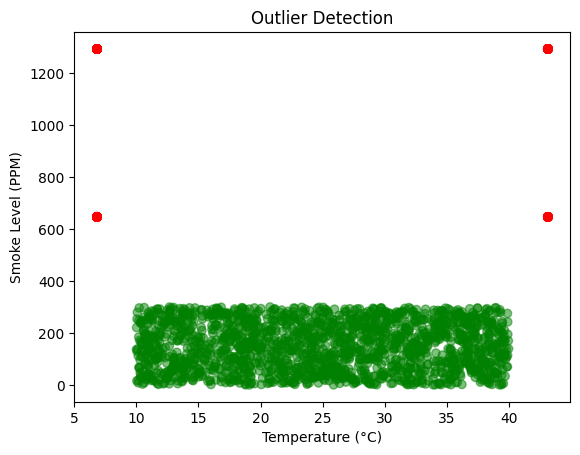

In [9]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np

# دا CWD 
data = pd.read_csv(r"sensor_data_training.csv")

# فصل البيانات إلى X (الخصائص) و y (التصنيف - Outlier أو Normal)
X = data[['Temperature_C', 'Humidity_Percentage', 'SmokeLevel_PPM', 'CarbonMonoxideLevel_PPM']]

# بناء نموذج Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X)

# التنبؤ بالقيم الشاذة على البيانات
predictions = iso_forest.predict(X)

# تحويل التنبؤات (-1 -> Outlier, 1 -> Normal) إلى نص
data['Outlier'] = ['Normal' if pred == 1 else 'Outlier' for pred in predictions]

# طباعة السجلات التي تم تصنيفها كـ "Outlier"
outliers_data = data[data['Outlier'] == 'Outlier']
print("Outliers detected:")
print(outliers_data)

# رسم بياني لعرض القيم الشاذة
import matplotlib.pyplot as plt

plt.scatter(data['Temperature_C'], data['SmokeLevel_PPM'], c=data['Outlier'].map({'Normal': 'green', 'Outlier': 'red'}), alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Smoke Level (PPM)')
plt.title('Outlier Detection')
plt.show()


In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np


# فصل البيانات إلى X (الخصائص) و y (التصنيف - Outlier أو Normal)
X = data[['Temperature_C', 'Humidity_Percentage', 'SmokeLevel_PPM', 'CarbonMonoxideLevel_PPM']]
y = data['Outlier']  # 1 = Outlier, 0 = Normal (العلامات المميزة)

# تقسيم البيانات إلى مجموعة تدريب واختبار (80% تدريب، 20% اختبار)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# بناء نموذج Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train)

# التنبؤ بالقيم الشاذة على بيانات الاختبار
predictions = iso_forest.predict(X_test)

# تحويل التنبؤات (-1 -> Outlier, 1 -> Normal) إلى "Outlier" و "Normal"
predictions = ['Outlier' if pred == -1 else 'Normal' for pred in predictions]

# حساب الدقة
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# حساب مصفوفة الالتباس
conf_matrix = confusion_matrix(y_test, predictions, labels=["Normal", "Outlier"])
print("Confusion Matrix:")
print(conf_matrix)

# عرض تقرير التصنيف (Classification Report)
class_report = classification_report(y_test, predictions, labels=["Normal", "Outlier"])
print("Classification Report:")
print(class_report)


Accuracy: 99.75%
Confusion Matrix:
[[357   1]
 [  0  42]]
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       358
     Outlier       0.98      1.00      0.99        42

    accuracy                           1.00       400
   macro avg       0.99      1.00      0.99       400
weighted avg       1.00      1.00      1.00       400



Test Data with Predictions:
   Temperature_C  Humidity_Percentage  SmokeLevel_PPM  \
0             25                   50             250   
1             30                   70             600   
2             45                   80            1200   
3             15                   40             100   
4             35                   60             350   
5             20                   65             150   

   CarbonMonoxideLevel_PPM  Outlier  
0                        5   Normal  
1                       35  Outlier  
2                       10  Outlier  
3                       30   Normal  
4                       20   Normal  
5                       25   Normal  


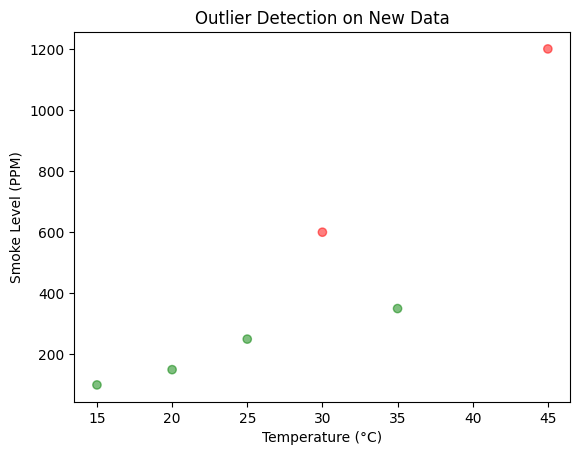

In [11]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np


# البيانات الجديدة التي نرغب في اختبار النموذج عليها
new_data = pd.DataFrame({
    'Temperature_C': [25, 30, 45, 15, 35, 20],
    'Humidity_Percentage': [50, 70, 80, 40, 60, 65],
    'SmokeLevel_PPM': [250, 600, 1200, 100, 350, 150],
    'CarbonMonoxideLevel_PPM': [5, 35, 10, 30, 20, 25],
})

# فصل البيانات إلى X (الخصائص)
X_new = new_data[['Temperature_C', 'Humidity_Percentage', 'SmokeLevel_PPM', 'CarbonMonoxideLevel_PPM']]


# التنبؤ بالقيم الشاذة على البيانات الجديدة
predictions = iso_forest.predict(X_new)

# تحويل التنبؤات (-1 -> Outlier, 1 -> Normal) إلى نص
new_data['Outlier'] = ['Normal' if pred == 1 else 'Outlier' for pred in predictions]

# طباعة النتائج الجديدة
print("Test Data with Predictions:")
print(new_data)

# رسم بياني لعرض القيم الشاذة مع البيانات الجديدة
import matplotlib.pyplot as plt

plt.scatter(new_data['Temperature_C'], new_data['SmokeLevel_PPM'], c=new_data['Outlier'].map({'Normal': 'green', 'Outlier': 'red'}), alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Smoke Level (PPM)')
plt.title('Outlier Detection on New Data')
plt.show()


In [12]:
# joblib.dump(model, "Finally_isolation_forest_model.joblib")
# print("تم حفظ المودل بنجاح!")


تم حفظ المودل بنجاح!


In [4]:
import joblib
import numpy as np
import pandas as pd

In [13]:
model = joblib.load("Finally_isolation_forest_model.joblib")


In [14]:
new_data = pd.DataFrame({
    'Temperature_C': [25, 30, 45, 15, 35, 20],
    'Humidity_Percentage': [50, 70, 80, 40, 60, 65],
    'SmokeLevel_PPM': [250, 600, 1200, 100, 350, 150],
    'CarbonMonoxideLevel_PPM': [5, 35, 10, 30, 20, 25],
})


Test Data with Predictions:
   Temperature_C  Humidity_Percentage  SmokeLevel_PPM  \
0             25                   50             250   
1             30                   70             600   
2             45                   80            1200   
3             15                   40             100   
4             35                   60             350   
5             20                   65             150   

   CarbonMonoxideLevel_PPM  Outlier  
0                        5   Normal  
1                       35  Outlier  
2                       10  Outlier  
3                       30   Normal  
4                       20   Normal  
5                       25   Normal  


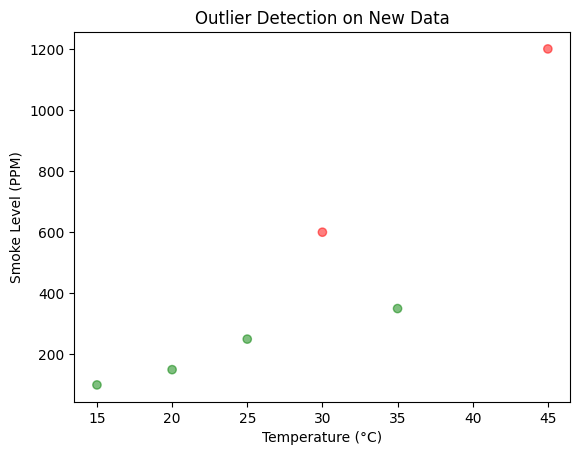

In [16]:
predictions = model.predict(new_data)

# تحويل التنبؤات (-1 -> Outlier, 1 -> Normal) إلى نص
new_data['Outlier'] = ['Normal' if pred == 1 else 'Outlier' for pred in predictions]

# طباعة النتائج الجديدة
print("Test Data with Predictions:")
print(new_data)

# رسم بياني لعرض القيم الشاذة مع البيانات الجديدة
import matplotlib.pyplot as plt

plt.scatter(new_data['Temperature_C'], new_data['SmokeLevel_PPM'], c=new_data['Outlier'].map({'Normal': 'green', 'Outlier': 'red'}), alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Smoke Level (PPM)')
plt.title('Outlier Detection on New Data')
plt.show()
